<a href="https://www.kaggle.com/code/parisrohan/customer-segmentation-using-rfm-modeling-k-means?scriptVersionId=96658385" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**What is Customer Segmentation?**
Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.

**Types of Segmentation factors:**
* Demographic (Age, Gender, Income, Location, Education, Ethnicity)
* Psychographic (Interests, Lifestyles, Priorities, Motivation, Influence)
* Behavioural (Purchasing habits, Spending habits, User status, Brand interactions)
* Geographic (zip code, city, country, climate)

**Why Segment Customers?**
* Test pricing options
* Focus on the most profitable customers
* Increase brand awareness
* Create and communicate targeted marketing messages


## Data collection and initial analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [2]:
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#for datetime operations
import datetime as dt

#for stats and plotting
import scipy.stats as stat
import pylab 

#for feature scaling
from sklearn.preprocessing import StandardScaler

#library for using K-Means algorithm
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [3]:
#read the dataset and store it into a dataframe
df_data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
#check the number of rows and columns present
df_data.shape

(1067371, 8)

**Observation**: Our dataset has 1067371 rows and 8 columns

In [5]:
#Check the feature datatypes
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


**Observation**: Features having null values are - Description, Customer ID

In [6]:
#making sure the above observation is correct
df_data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

## Feature Description
* **InvoiceNo:** Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

* **StockCode:** Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

* **Description:** Product (item) name. Nominal.

* **Quantity:** The quantities of each product (item) per transaction. Numeric.

* **InvoiceDate:** Invice date and time. Numeric. The day and time when a transaction was generated.

* **UnitPrice:** Unit price. Numeric. Product price per unit in sterling (Â£).

* **CustomerID:** Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

* **Country:** Country name. Nominal. The name of the country where a customer resides.

## Data Cleaning

### Analyzing Country feature

In [7]:
cust_country = df_data[['Country', 'Customer ID']].drop_duplicates()
cust_country.groupby(['Country'])['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)
#df_data.groupby(['Country'])['Customer ID'].head()

,Country,Customer ID
40,United Kingdom,5410
15,Germany,107
14,France,95
34,Spain,41
3,Belgium,29
30,Portugal,24
26,Netherlands,23
36,Switzerland,22
35,Sweden,19
20,Italy,17


**Observation:** Most number of customer's belong from UK.
So we will only customer the customer's from United Kingdom for our analysis

In [8]:
#keep only UK customer data
df_data = df_data.query("Country== 'United Kingdom'").reset_index(drop=True)

### Analyzing Customer ID feature

In [9]:
#From the df_info() command we can see that the 'Customer ID' feature has some null values
print('Number of customers having no ID: ',df_data['Customer ID'].isnull().sum())

Number of customers having no ID:  240029


In [10]:
#Ignore the transactions where there is no Customer ID
df_data = df_data[df_data['Customer ID'].notna()==True]

### Analyzing Price feature

In [11]:
#As per our understanding, the Price feature does not contain any NULL values
#Check if there is any record with Price = 0
df_data[df_data['Price']==0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4399,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom
6424,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom
15306,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231.0,United Kingdom
17855,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
17856,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom


**Observation**: From the above table we can see that there are many records where the Price is 0 value. This can be treated as NULL 

In [12]:
#Check if there are any negative values in Price
df_data[df_data['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [13]:
#We will drop the records who have Price as 0
index_name = df_data[(df_data['Price']==0)].index
df_data.drop(index_name, inplace = True)

### Analyzing the InvoiceDate feature

In [14]:
#data start
df_data['InvoiceDate'].min()

'2009-12-01 07:45:00'

In [15]:
#data stop
df_data['InvoiceDate'].max()

'2011-12-09 12:49:00'

**Observation:** The dataset has records from 2009/12/01 to 2011/12/09

### Analyzing the Quantity feature

In [16]:
#Check if there are any values as 0
df_data[df_data['Quantity']==0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [17]:
#Check if there are any negative values
df_data[df_data['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
157,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.0,United Kingdom
158,C489459,90200D,PINK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.0,United Kingdom
159,C489459,90200B,BLACK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.0,United Kingdom
160,C489459,90200E,GREEN SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.0,United Kingdom
161,C489459,90200C,BLUE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.0,United Kingdom
...,...,...,...,...,...,...,...,...
979985,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
981041,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
981215,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
981216,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


**Observation**: There are 16005 records with negative quantity. This is because the corresponding Invoice entry has been canceled -> The Invoice starts with 'C' for cancelled transactions


In [18]:
#We will drop the records who have been cancelled -> Invoice start with C
index_name = df_data[(df_data['Quantity']<0)].index
df_data.drop(index_name, inplace = True)

### Analyzing the Description feature

In [19]:
df_data[df_data['Description'].isna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [20]:
df_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [21]:
#Create a new feature named TotalPrice by multiplying Quantity and Price feature
df_data['TotalPrice'] = df_data['Quantity'] * df_data['Price']

In [22]:
#Get the top customers
df_data.groupby("Customer ID")["TotalPrice"].sum()

Customer ID
12346.0    77556.46
12608.0      415.79
12745.0      723.85
12746.0      254.55
12747.0     9276.54
             ...   
18283.0     2736.65
18284.0      461.68
18285.0      427.00
18286.0     1296.43
18287.0     4182.99
Name: TotalPrice, Length: 5350, dtype: float64

In [23]:
#data after cleaning
df_data2 = df_data.copy(deep=True)
df_data2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [24]:
df_data2.shape

(725250, 9)

## **RFM** Modelling

**RFM is an acronym for recency, frequency, and monetary value.**

* Recency: How recently a customer has made a purchase
* Frequency: How often a customer makes a purchase
* Monetary Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

**Recency**
* The more recently a customer has made a purchase with a company, the more likely they will continue to keep the business and brand in mind for subsequent purchases. Compared with customers who have not bought from the business in months or even longer periods, the likelihood of engaging in future transactions with recent customers is arguably higher.
* Such information can be used to get recent customers to revisit the business and spend more. In an effort not to overlook lapsed customers, marketing efforts might be made to remind them that it's been a while since their last transaction, while offering them an incentive to resume buying.


**Frequency**
* The frequency of a customer’s transactions may be affected by factors such as the type of product, the price point for the purchase, and the need for replenishment or replacement. If the purchase cycle can be predicted — for example when a customer needs to buy more groceries — marketing efforts may be directed towards reminding them to visit the business when staple items run low.


**Monetary Value**
* Monetary value stems from how much the customer spends. A natural inclination is to put more emphasis on encouraging customers who spend the most money to continue to do so. While this can produce a better return on investment in marketing and customer service, it also runs the risk of alienating customers who have been consistent but may not spend as much with each transaction.

Reference:
https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

In [25]:
#We will assign the next day after the last date recorded in the dataset as 'today_date'
today_date = dt.datetime(2011, 12, 11)

In [26]:
#We will change the datatype of InvoiceDate to datetime from object
df_data2['InvoiceDate'] = df_data2['InvoiceDate'].astype('datetime64')

* Recency is calculated by subtracting today_date - the last day the customer made a purchase
* Frequency is calculated by getting the unique count of Invoices
* Monetary value is calculated by getting the sum of totalprice

In [27]:
rfm = df_data2.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [28]:
rfm=rfm.reset_index()
rfm.head()

,Customer ID,InvoiceDate,Invoice,TotalPrice
0,12346.0,326,12,77556.46
1,12608.0,405,1,415.79
2,12745.0,487,2,723.85
3,12746.0,541,1,254.55
4,12747.0,3,26,9276.54


In [29]:
#renaming the column names
rfm.columns = ['CustomerID','Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12608.0,405,1,415.79
2,12745.0,487,2,723.85
3,12746.0,541,1,254.55
4,12747.0,3,26,9276.54


In [30]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,5350.000000,5350.000000,5350.000000,5350.000000
mean,15557.362617,203.546168,6.269346,2751.990190
std,1581.161762,209.973818,11.995550,12080.466564
min,12346.000000,1.000000,1.000000,2.950000
25%,14191.250000,26.000000,1.000000,336.167500
50%,15565.500000,99.000000,3.000000,849.910000
75%,16922.750000,382.000000,7.000000,2214.905000
max,18287.000000,739.000000,336.000000,608821.650000


## Feature Transformation

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

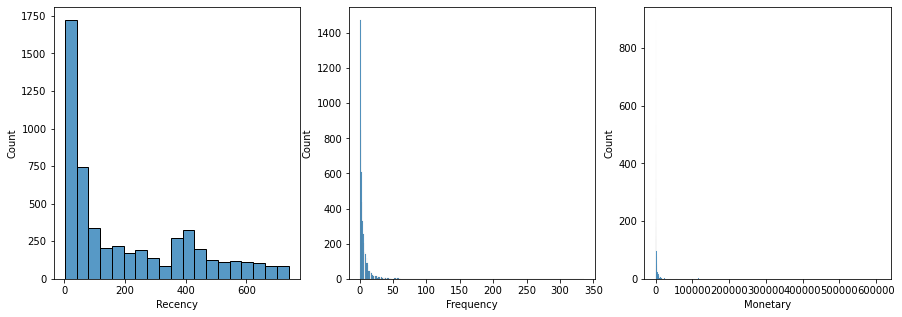

In [31]:
#Plot data distribution
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(data=rfm, x='Recency')

plt.subplot(1,3,2)
sns.histplot(data=rfm, x='Frequency')

plt.subplot(1,3,3)
sns.histplot(data=rfm, x='Monetary')

In [32]:
#apply log transformation 
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1).round(3)

In [33]:
rfm_log.head()

,Recency,Frequency,Monetary
0,5.787,2.485,11.259
1,6.004,0.000,6.030
2,6.188,0.693,6.585
3,6.293,0.000,5.539
4,1.099,3.258,9.135


<AxesSubplot:xlabel='Monetary', ylabel='Count'>

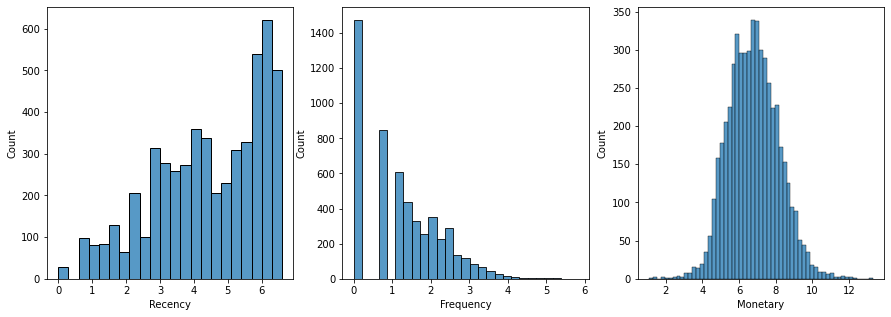

In [34]:
#Plot data distribution after log transformation
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(data=rfm_log, x='Recency')

plt.subplot(1,3,2)
sns.histplot(data=rfm_log, x='Frequency')

plt.subplot(1,3,3)
sns.histplot(data=rfm_log, x='Monetary')

In [35]:
rfm_log.describe()

,Recency,Frequency,Monetary
count,5350.000000,5350.000000,5350.000000
mean,4.442442,1.208028,6.793477
std,1.596148,1.030144,1.380669
min,0.000000,0.000000,1.082000
25%,3.258000,0.000000,5.817250
50%,4.595000,1.099000,6.745000
75%,5.945000,1.946000,7.702750
max,6.605000,5.817000,13.319000


## Feature Scaling

In [36]:
#rfm_scaled = rfm_log.copy(deep=True)

In [37]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [38]:
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns= rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
0,0.842456,1.239721,3.234622
1,0.978421,-1.172788,-0.553028
2,1.093709,-0.500003,-0.151011
3,1.159499,-1.172788,-0.908686
4,-2.094890,1.990171,1.696093


## K-Means clustering

**Highlevel overview of K-Means algorithm:**
* Vectorize feature values to define n-dimensional coordinates
* **Decide value of 'K'** -> K is the number of clusters
* K number of clusters are created with K centroids
* Each datapoint is assigned to nearest cluster
* New centroids are chosen based on Euclidian distance
* Data points are reassigned to nearest cluster
* The above steps are repeated untill there are no change.

* From the above explanation it can be observed that the value of **K** needs to be determined before hand.
* **Elbow Method** is used to find the optimal value of K

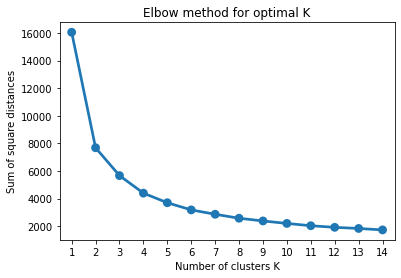

In [39]:
#wcss stands for within cluster sum of squares
wcss={}

for k in range(1,15):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    km = km.fit(rfm_scaled)
    wcss[k] = km.inertia_
    
#Plot graph for the wcss values and the number of clusters
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of square distances')
plt.title('Elbow method for optimal K')
plt.show()

**Observation:** Choose the value K=3

In [40]:
#Build K Means clustering model using K=3
kmean_model = KMeans(n_clusters=3, init='k-means++', max_iter=1000)
kmean_model.fit(rfm_scaled)

#find the clusters for the records given in our dataset
rfm['Cluster'] = kmean_model.labels_

#check the datset
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,12,77556.46,0
1,12608.0,405,1,415.79,1
2,12745.0,487,2,723.85,1
3,12746.0,541,1,254.55,1
4,12747.0,3,26,9276.54,0


In [41]:
rfm.Cluster.value_counts()

2    2140
1    2010
0    1200
Name: Cluster, dtype: int64

In [42]:
rfm[rfm['Cluster']==0].describe()

,CustomerID,Recency,Frequency,Monetary,Cluster
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.0
mean,15527.768333,28.707500,17.885000,9191.211948,0.0
std,1587.569496,46.136436,21.208212,24346.880080,0.0
min,12346.000000,1.000000,2.000000,489.540000,0.0
25%,14171.000000,5.000000,9.000000,2802.992500,0.0
50%,15519.500000,15.000000,12.000000,4481.030000,0.0
75%,16928.250000,32.000000,19.000000,8217.080000,0.0
max,18287.000000,498.000000,336.000000,608821.650000,0.0


In [43]:
rfm[rfm['Cluster']==1].describe()

,CustomerID,Recency,Frequency,Monetary,Cluster
count,2010.000000,2010.000000,2010.000000,2010.000000,2010.0
mean,15575.561692,369.924876,1.353731,325.484369,1.0
std,1602.128077,206.700421,0.617279,249.499212,0.0
min,12608.000000,5.000000,1.000000,2.950000,1.0
25%,14190.500000,202.000000,1.000000,156.775000,1.0
50%,15550.000000,394.500000,1.000000,270.855000,1.0
75%,16973.750000,535.750000,2.000000,417.847500,1.0
max,18285.000000,739.000000,8.000000,2803.200000,1.0


In [44]:
rfm[rfm['Cluster']==2].describe()

,CustomerID,Recency,Frequency,Monetary,Cluster
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.0
mean,15556.864019,145.314953,4.372897,1420.312897,2.0
std,1558.056572,149.591877,2.313692,1430.582364,0.0
min,12822.000000,2.000000,1.000000,102.450000,2.0
25%,14205.000000,32.000000,3.000000,723.985000,2.0
50%,15615.500000,78.000000,4.000000,1101.955000,2.0
75%,16861.250000,216.000000,5.000000,1745.327500,2.0
max,18286.000000,692.000000,20.000000,44534.300000,2.0


* Cluster 2: High M, High F, Low R
* Cluster 1: Low M, Low F, High R
* Cluster 0: Medium M, Medium F, Medium R